In [1]:
from fastai.vision.all import *

In [3]:
set_seed(16)

In [4]:
path = Path("data_engineered")

In [5]:
path

Path('data_engineered')

In [6]:
path.ls()

(#5) [Path('data_engineered/validation_data'),Path('data_engineered/testing_data'),Path('data_engineered/train_data.csv'),Path('data_engineered/feature_engineer_fastai_readable_format_train.py'),Path('data_engineered/train')]

In [7]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [8]:
train_df = pd.read_csv(path/'train_data.csv')

In [9]:
train_df

image_id  label
0       UID_H20_2_1_hem.bmp      0
1      UID_H13_15_2_hem.bmp      0
2      UID_H40_19_6_hem.bmp      0
3      UID_H23_5_10_hem.bmp      0
4      UID_H20_31_2_hem.bmp      0
...                     ...    ...
10656   UID_51_83_2_all.bmp      1
10657    UID_44_2_3_all.bmp      1
10658    UID_46_7_3_all.bmp      1
10659    UID_46_7_2_all.bmp      1
10660  UID_51_118_9_all.bmp      1

[10661 rows x 2 columns]

<AxesSubplot:>

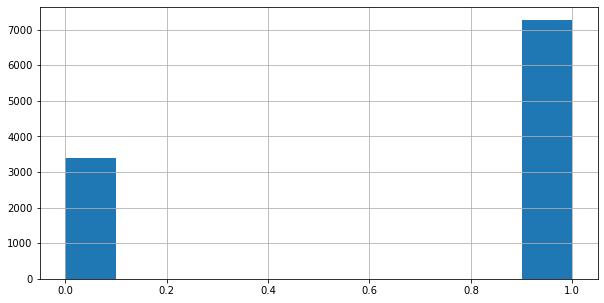

In [10]:
train_df['label'].hist(figsize = (10, 5))

In [11]:
train_df['path'] = train_df['image_id'].map(lambda x:path/'train'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(10)

label                                         path
0      1   data_engineered/train/UID_32_34_10_all.bmp
1      1     data_engineered/train/UID_43_6_2_all.bmp
2      0   data_engineered/train/UID_H23_22_3_hem.bmp
3      1    data_engineered/train/UID_48_28_8_all.bmp
4      0   data_engineered/train/UID_H10_54_1_hem.bmp
5      1    data_engineered/train/UID_47_31_3_all.bmp
6      1    data_engineered/train/UID_25_12_1_all.bmp
7      0  data_engineered/train/UID_H10_141_2_hem.bmp
8      1     data_engineered/train/UID_25_4_3_all.bmp
9      1     data_engineered/train/UID_35_9_7_all.bmp

In [12]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 
im.show()
plt.show()

450 450


In [13]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [20]:
import albumentations

In [37]:
def get_train_aug(sz): 
    return albumentations.Compose([
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.15, 
                sat_shift_limit=0.15, 
                val_shift_limit=0.15, 
                p=0.25
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.25
            ),
            albumentations.CoarseDropout(p=0.1),
            albumentations.Cutout(p=0.1)
])

def get_valid_aug(sz): 
    return albumentations.Compose([
    albumentations.CenterCrop(sz,sz, p=1.),
    albumentations.Resize(sz,sz)
], p=1.)

In [38]:
def get_dls(sz,bs):
    item_tfms = AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                                   valid_pct=0.2, #80-20 train-validation random split
                                   seed=999, #seed
                                   label_col=0, #label is in the first column of the DataFrame
                                   fn_col=1, #filename/path is in the second column of the DataFrame
                                   bs=bs, #pass in batch size
                                   item_tfms=item_tfms, #pass in item_tfms
                                   batch_tfms=batch_tfms) #pass in batch_tfms
    return dls

In [41]:
dls = get_dls(224,16)


/home/p/.is/anaconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [43]:
resnet50

<function torchvision.models.resnet.resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>

In [44]:
ranger

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

In [56]:
learn = cnn_learner(dls, resnet50, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(), metrics=F1Score())

In [47]:
F1Score

<function fastai.metrics.F1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None)>

In [49]:
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

In [50]:
@patch
def fine_tune_flat(self:Learner, epochs, base_lr=4e-3, freeze_epochs=1, lr_mult=100, pct_start=0.75, 
                   first_callbacks = [], second_callbacks = [], **kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.99, cbs=first_callbacks, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, cbs=second_callbacks)

SuggestedLRs(valley=0.0002290867705596611)

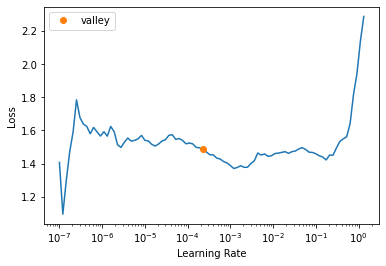

In [57]:
learn.lr_find()

In [52]:
cbs1 = [MixUp(alpha = 0.7)]
cbs2 = [MixUp(alpha = 0.3)]

In [58]:
learn.fine_tune_flat(5, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [59]:
learn.save('stage-1')


Path('models/stage-1.pth')

In [ ]:
learn.fine_tune_flat(5, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-2')


In [ ]:
learn.fine_tune_flat(7, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-3')

In [ ]:
learn.fine_tune_flat(10, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-4')

In [ ]:
cbs1 = [MixUp(alpha = 0.5)]
cbs2 = [MixUp(alpha = 0.15)]

In [ ]:
learn.fine_tune_flat(10, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-5')

In [ ]:
learn.fine_tune_flat(10, base_lr=1e-3, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-6')

In [ ]:
learn.fine_tune_flat(5, base_lr=1e-4, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-7')

In [ ]:
learn.fine_tune_flat(10, base_lr=1e-5, pct_start=0.72, first_callbacks=cbs1, second_callbacks=cbs2)

In [ ]:
learn.save('stage-8')